**Name : Bq Desy Hardianti**

Big Data Analytics Student Final Project

**The Dataset I use from URL **: 
https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

**Data set contains = **5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).


**Description of the problem:** 
Chest X-ray images (anterior-posterior) were selected from retrospective cohorts of pediatric patients of **one to five years old from Guangzhou Women and Children’s Medical Center, Guangzhou.** All chest X-ray imaging was performed as part of patients’ routine clinical care.

For the analysis of chest x-ray images, all chest radiographs were initially screened for quality control by removing all low quality or unreadable scans. The diagnoses for the images were then graded by two expert physicians before being cleared for training the AI system. In order to account for any grading errors, the evaluation set was also checked by a third expert.




In [1]:
!pip install -q kaggle

In [2]:
from google.colab import files

files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"bqdesyhardianti","key":"68da920cfea76c5740d10af0b382c10c"}'}

In [3]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

100% 2.29G/2.29G [00:25<00:00, 103MB/s] 
100% 2.29G/2.29G [00:25<00:00, 96.3MB/s]


In [4]:
! mkdir train
! unzip chest-xray-pneumonia.zip -d tr

Streaming output truncated to the last 5000 lines.
  inflating: tr/chest_xray/train/NORMAL/IM-0435-0001-0001.jpeg  
  inflating: tr/chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: tr/chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: tr/chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: tr/chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: tr/chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: tr/chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: tr/chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: tr/chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: tr/chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: tr/chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: tr/chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: tr/chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: tr/chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: tr/chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: tr/chest_xr

The Dataset I use from URL : https://www.kaggle.com/paultimothymooney/chest-xray-pneumonia

Data set contains = 5,863 X-Ray images (JPEG) and 2 categories (Pneumonia/Normal).

In [5]:
#Importing the necessary libraries

import numpy as np  # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import random

import keras
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc

import cv2
import os


In [6]:
# Loadin and sorting the test, train and val so we can know how much Xray values we have in each one of the folders
IMG_SIZE =  100

labels = ['NORMAL','PNEUMONIA']
def get_training_data(library_dir):
    data = [] 
    for label in labels: 
        path = os.path.join(library_dir, label)#Allows us to access subfolders of test,train,val
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE) #read the xray and convert it to gray scale
                resized_arr = cv2.resize(img_arr, (IMG_SIZE, IMG_SIZE)) # Reshaping images size
                data.append([resized_arr, class_num])
            except Exception as e:
                #print(e)
                pass
    return np.array(data)

#Loading the Dataset       
test = get_training_data('/content/tr/chest_xray/test')
train = get_training_data('/content/tr/chest_xray/train')
val = get_training_data('/content/tr/chest_xray/val') 


print('size of test set :',len(test))
print('size of train set :',len(train))
print('size of validation set :',len(val))
print("Dataset Test       : {0} ({1:0.2f}%)".format(len(test), (len(test)/(len(test)+len(train)+len(val))) * 100.0))
print("Dataset Train      : {0} ({1:0.2f}%)".format(len(train), (len(train)/(len(test)+len(train)+len(val))) * 100.0))
print("Dataset Validation : {0} ({1:0.2f}%)".format(len(val), (len(val)/(len(test)+len(train)+len(val))) * 100.0))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


size of test set : 624
size of train set : 5216
size of validation set : 16
Dataset Test       : 624 (10.66%)
Dataset Train      : 5216 (89.07%)
Dataset Validation : 16 (0.27%)


 
train_set:

Pneumonia cases : 3875
Normals   cases : 1341

 
validation_set:

Pneumonia cases : 8
Normals   cases : 8




/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'PNEUMONIA')

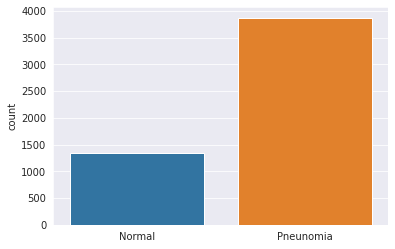

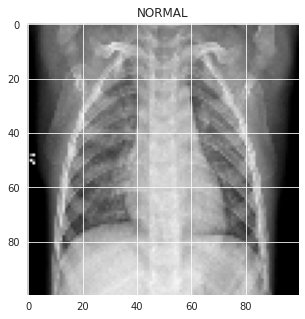

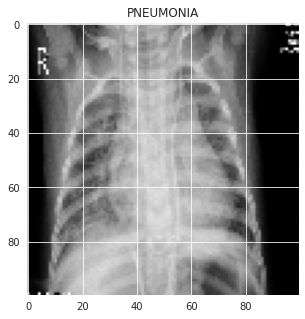

In [7]:
l = []
pneumonia_count = 0
normal_count = 0

for i in train:
    if(i[1] == 1):
        l.append("Pneunomia")
        pneumonia_count = pneumonia_count + 1
    else:
        l.append("Normal")
        normal_count = normal_count + 1

sns.set_style('darkgrid')
sns.countplot(l)  

print(' \ntrain_set:\n')
print('Pneumonia cases :',pneumonia_count)
print('Normals   cases :',normal_count)
print('')

pneumonia_count = 0
normal_count = 0

for i in val:
    if(i[1] == 1):
        pneumonia_count = pneumonia_count + 1
    else:
        normal_count = normal_count + 1

print(' \nvalidation_set:\n')
print('Pneumonia cases :',pneumonia_count)
print('Normals   cases :',normal_count)
print('\n')

plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])


From the result above We got from training data:
Pneumonia cases : 3875
Normals   cases : 1341 



In [8]:
#The training data seems imbalanced .
# To increase the no. of training examples, we will use data augmentation

# Store each {data,label} in 2 different lists
x_train = []
y_train = [] 

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)


In [9]:
# confirm pixel range is 0-255
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

# resize data for deep learning 
x_train = x_train.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y_test = np.array(y_test)


In [10]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 35,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.3, # Randomly zoom image 
        width_shift_range=0.15,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.15,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)


In [11]:
#build the model (CNN) -- 1
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (IMG_SIZE,IMG_SIZE,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))


model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))


model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()
#define callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
#fit the training data to the model
EPOCHS = 12
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = EPOCHS , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 100, 100, 32)      320       
_________________________________________________________________
batch_normalization (BatchNo (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 25, 25, 64)        1

In [12]:
#Analysis after Model Training 1 #
def show_predection_examples(pred_class,pred_prob,nb_examples):

    fig = plt.figure(figsize=(10, 10))

    rand_index = 0
    prob = 0
    for i in range(nb_examples):

        rand_index = random.randint(0,len(pred_class))
        plt.subplot(3,2,i+1)

        # label 0 is 'Pneunomia' ,label 0 is 'Normal'     
        img_label = int(pred_class[rand_index])  

        prob = np.round(pred_prob[rand_index],3)     #(float) probabilty that the image label is 'Pneunomia'

        if img_label == 1:
            pass       
        else:
             prob = np.round(1 - prob,3)             #(float) probabilty that the image label is 'Normal' 
             # prediction probabilty will be a float number close to 0 , we might understand its definition if we 
             # compute the complement to 1 ; prob(Normal) = 1 - sigmoid_probability_evalutaion , this is only needed 
             # when we need to show the prediction probability of nb_examples images...

        plt.xticks([])
        plt.yticks([])
        plt.imshow(x_test[rand_index].reshape(IMG_SIZE,IMG_SIZE), cmap="viridis", interpolation='none')
        plt.title("Predicted Class {},Actual Class {}".format(pred_class[rand_index], y_test[rand_index]))
        plt.xlabel(labels[img_label]+': '+str(prob))
        plt.subplots_adjust(bottom=0.5, wspace=0.5, hspace=0.5)

    plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


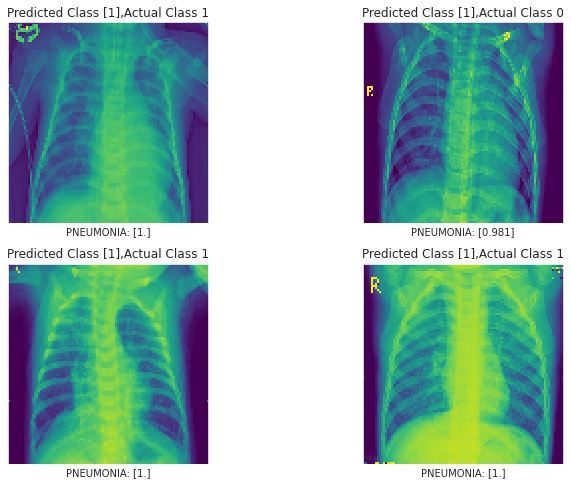

In [13]:
###Definitions
# Define 1:  train & validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

## Define 2: train & validation AUC
train_auc_name = list(history.history.keys())[3]
val_auc_name = list(history.history.keys())[1]
train_auc = history.history[train_auc_name]
val_auc = history.history[val_auc_name]

## Define 3: y_pred & y_true : y_test
prediction_probability = model.predict(x_test)
prediction_class= model.predict_classes(x_test)
y_pred = (prediction_class > 0.5).T[0]
y_pred_prob = prediction_probability.T[0]

show_predection_examples(prediction_class,prediction_probability,4)

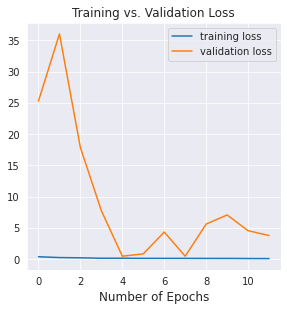

In [14]:
#-----------------------------------Building Plots-----------------------------------#

fig = plt.figure(figsize=(10, 10))

# PLOT 1: TRAIN VS. VALIDATION LOSS 
plt.subplot(2,2,1)
plt.title("Training vs. Validation Loss")
plt.plot(train_loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.xlabel("Number of Epochs", size = EPOCHS)
plt.legend()


Text(105.0, 0.5, 'Actual')

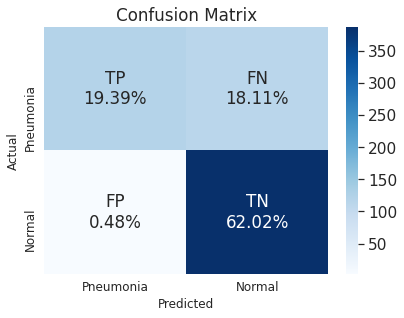

In [15]:

# PLOT 2: CONFUSION MATRIX
fig = plt.figure(figsize=(14, 10))
plt.subplot(2,2,3)

    # Set up the labels for in the confusion matrix
cm = confusion_matrix(y_test, y_pred)
names = ['TP', 'FN', 'FP', 'TN']
counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
labels = np.asarray(labels).reshape(2,2)
ticklabels = ['Pneumonia','Normal']

    # Create confusion matrix as heatmap
sns.set(font_scale = 1.4)
ax = sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', xticklabels=ticklabels, yticklabels=ticklabels )
plt.xticks(size=EPOCHS)
plt.yticks(size=EPOCHS)
plt.title("Confusion Matrix")
plt.xlabel("Predicted", size= EPOCHS)
plt.ylabel("Actual", size= EPOCHS) 


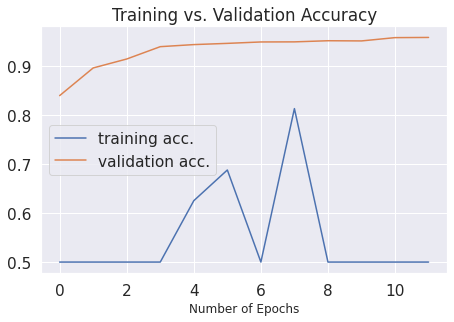

In [16]:
# PLOT 3: TRAIN VS. VALIDATION AUC
fig = plt.figure(figsize=(16, 10))
plt.subplot(2,2,2)
plt.title("Training vs. Validation Accuracy")
plt.plot(train_auc, label='training acc.')
plt.plot(val_auc, label='validation acc.')
plt.xlabel("Number of Epochs", size = EPOCHS)
plt.legend()


[Classification Metrics Summary]
Accuracy = 81.41% | Precision = 77.40% | Recall = 99.23% | Specifity = 51.71% | F1 Score = 86.97%


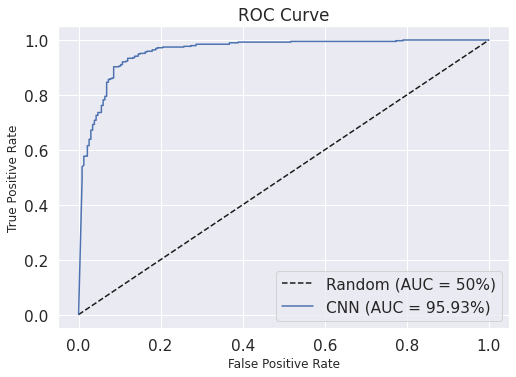

In [17]:
# PLOT 4: ROC CURVE
fig = plt.figure(figsize=(14, 10))
plt.subplot(2,2,4)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
plt.xlabel('False Positive Rate', size = EPOCHS)
plt.ylabel('True Positive Rate', size = EPOCHS)
plt.legend(loc='best')

# END PLOTS
plt.tight_layout()

# Summary Statistics

    #Accuracy : 1 - (Average Classification Error) = (TP + TN) / (TP + FN + TN + FP)  --> % positive out of all predicted positives
    #Precision : how many selected items are relevant = TP / (TP + FP)                --> % positive out of all predicted positives
    #Recall : how many relevant items are selected = TP / (TP + FN)                   --> % positive out of all supposed to be positives
    #Specifity :                                                                      --> % negative out of all supposed to be negatives
    #F1-score : harmonic mean between Precision and Recall = (2*precision * recall) / (precision + recall)

#cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
TN, FP, FN, TP = cm.ravel()         
accuracy = (TP + TN) / np.sum(cm)   
precision = TP / (TP+FP)            
recall =  TP / (TP+FN)              
specifity = TN / (TN+FP)           
f1 = 2 * precision * recall / (precision + recall)
stats_summary = '[Classification Metrics Summary]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specifity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specifity, f1)
print(stats_summary)


In [19]:
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization


In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

#build the model (CNN - 2)
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (IMG_SIZE,IMG_SIZE,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))


model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))


model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 100, 100, 32)      320       
_________________________________________________________________
batch_normalization_8 (Batch (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 50, 50, 32)        9248      
_________________________________________________________________
batch_normalization_9 (Batch (None, 50, 50, 32)        128       
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 25, 25, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 25, 25, 64)       

In [22]:
##Set Hyperparameter Learning Rate 0,03
#define callbacks
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.03)
#fit the training data to the model
EPOCHS = 30
history = model.fit(datagen.flow(x_train,y_train, batch_size = 32) ,epochs = EPOCHS , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")


Epoch 1/30
163/163 [==============================] - 93s 560ms/step - loss: 0.5569 - accuracy: 0.8042 - val_loss: 9.9056 - val_accuracy: 0.5000
Epoch 2/30
163/163 [==============================] - 91s 556ms/step - loss: 0.2930 - accuracy: 0.8812 - val_loss: 15.6567 - val_accuracy: 0.5000
Epoch 3/30
163/163 [==============================] - 91s 557ms/step - loss: 0.2499 - accuracy: 0.9052 - val_loss: 12.1031 - val_accuracy: 0.5000
Epoch 4/30
163/163 [==============================] - 91s 557ms/step - loss: 0.2117 - accuracy: 0.9104 - val_loss: 9.6068 - val_accuracy: 0.5000
Epoch 5/30
163/163 [==============================] - 91s 559ms/step - loss: 0.2071 - accuracy: 0.9191 - val_loss: 19.5666 - val_accuracy: 0.5000
Epoch 6/30
163/163 [==============================] - 91s 557ms/step - loss: 0.1845 - accuracy: 0.9345 - val_loss: 7.5928 - val_accuracy: 0.5000
Epoch 7/30
163/163 [==============================] - 91s 560ms/step - loss: 0.1898 - accuracy: 0.9271 - val_loss: 1.0821 - val

In [26]:

#Analysis after Model Training 1 #
def show_predection_examples(pred_class,pred_prob,nb_examples):

    fig = plt.figure(figsize=(10, 10))

    rand_index = 0
    prob = 0
    for i in range(nb_examples):

        rand_index = random.randint(0,len(pred_class))
        plt.subplot(3,2,i+1)

        # label 1 is 'Pneunomia' ,label 0 is 'Normal'     
        img_label = int(pred_class[rand_index])  

        prob = np.round(pred_prob[rand_index],3)     #(float) probabilty that the image label is 'Pneunomia'

        if img_label == 1:
            pass       
        else:
             prob = np.round(1 - prob,3)             #(float) probabilty that the image label is 'Normal' 
             # prediction probabilty will be a float number close to 0 , we might understand its definition if we 
             # compute the complement to 1 ; prob(Normal) = 1 - sigmoid_probability_evalutaion , this is only needed 
             # when we need to show the prediction probability of nb_examples images...

        plt.xticks([])
        plt.yticks([])
        plt.imshow(x_test[rand_index].reshape(IMG_SIZE,IMG_SIZE), cmap="viridis", interpolation='none')
        plt.title("Predicted Class {},Actual Class {}".format(pred_class[rand_index], y_test[rand_index]))
        plt.xlabel(labels[img_label]+': '+str(prob))
        plt.subplots_adjust(bottom=0.5, wspace=0.5, hspace=0.5)

    plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


UFuncTypeError: ignored

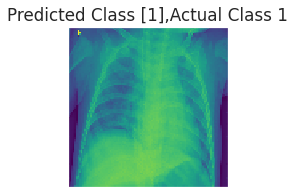

In [33]:
import numpy as np

###Definitions
# Define 1:  train & validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

## Define 2: train & validation AUC
train_auc_name = list(history.history.keys())[3]
val_auc_name = list(history.history.keys())[1]
train_auc = history.history[train_auc_name]
val_auc = history.history[val_auc_name]

## Define 3: y_pred & y_true : y_test
prediction_probability = model.predict(x_test)
prediction_class= model.predict_classes(x_test)
#prediction_class =np.argmax(model.predict(x_test), axis=-1)
y_pred = (prediction_class > 0.5).T[0]
y_pred_prob = prediction_probability.T[0]

show_predection_examples(prediction_class,prediction_probability,4)

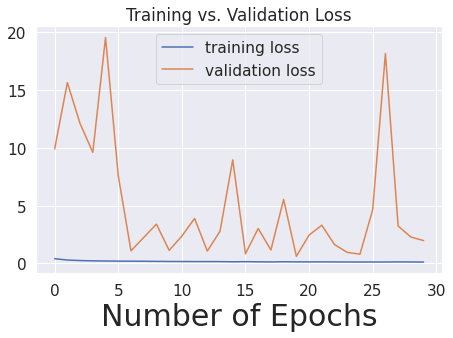

In [34]:
#Building Plots#
fig = plt.figure(figsize=(16, 10))

# PLOT 1: TRAIN VS. VALIDATION LOSS epoch 30
plt.subplot(2,2,1)
plt.title("Training vs. Validation Loss")
plt.plot(train_loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.xlabel("Number of Epochs", size = EPOCHS)
plt.legend()

Text(97.5, 0.5, 'Actual')

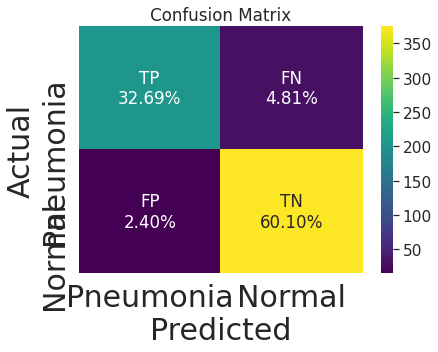

In [35]:
# PLOT 2: CONFUSION MATRIX
fig = plt.figure(figsize=(14, 10))
plt.subplot(2,2,3)

    # Set up the labels for in the confusion matrix
cm = confusion_matrix(y_test, y_pred)
names = ['TP', 'FN', 'FP', 'TN']
counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
labels = np.asarray(labels).reshape(2,2)
ticklabels = ['Pneumonia','Normal']

    # Create confusion matrix as heatmap
sns.set(font_scale = 1.4)
ax = sns.heatmap(cm, annot=labels, fmt='', cmap='viridis', xticklabels=ticklabels, yticklabels=ticklabels )
plt.xticks(size=EPOCHS)
plt.yticks(size=EPOCHS)
plt.title("Confusion Matrix")
plt.xlabel("Predicted", size= EPOCHS)
plt.ylabel("Actual", size= EPOCHS) 



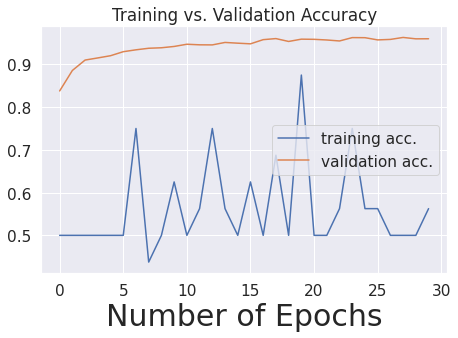

In [36]:
# PLOT 3: TRAIN VS. VALIDATION AUC
fig = plt.figure(figsize=(16, 10))
plt.subplot(2,2,2)
plt.title("Training vs. Validation Accuracy")
plt.plot(train_auc, label='training acc.')
plt.plot(val_auc, label='validation acc.')
plt.xlabel("Number of Epochs", size = EPOCHS)
plt.legend()

[Classification Metrics Summary]
Accuracy = 92.79% | Precision = 92.59% | Recall = 96.15% | Specifity = 87.18% | F1 Score = 94.34%


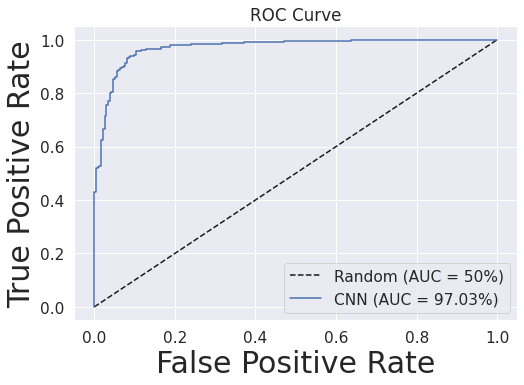

In [37]:
# PLOT 4: ROC CURVE
fig = plt.figure(figsize=(14, 10))
plt.subplot(2,2,4)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
plt.xlabel('False Positive Rate', size = EPOCHS)
plt.ylabel('True Positive Rate', size = EPOCHS)
plt.legend(loc='best')

# END PLOTS
plt.tight_layout()

# Summary Statistics

    #Accuracy : 1 - (Average Classification Error) = (TP + TN) / (TP + FN + TN + FP)  --> % positive out of all predicted positives
    #Precision : how many selected items are relevant = TP / (TP + FP)                --> % positive out of all predicted positives
    #Recall : how many relevant items are selected = TP / (TP + FN)                   --> % positive out of all supposed to be positives
    #Specifity :                                                                      --> % negative out of all supposed to be negatives
    #F1-score : harmonic mean between Precision and Recall = (2*precision * recall) / (precision + recall)

#cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
TN, FP, FN, TP = cm.ravel()         
accuracy = (TP + TN) / np.sum(cm)   
precision = TP / (TP+FP)            
recall =  TP / (TP+FN)              
specifity = TN / (TN+FP)           
f1 = 2 * precision * recall / (precision + recall)
stats_summary = '[Classification Metrics Summary]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specifity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specifity, f1)
print(stats_summary)


From data above we can see from AUC (area under the curve) value here we get quite good prediction for both models. 

As we can see that ROC curves of both models are not significantly different. 
We got AUC for Model 1 = 95,93% and Model 2 =97,03%
Even it's so, we still believe that hyperparameters have effected big enough to the accuracy of the model in circumstance situation

In [38]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout , BatchNormalization

#build the model (CNN - 3)
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (IMG_SIZE,IMG_SIZE,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))


model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))


model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))


model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()


Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_14 (Conv2D)           (None, 100, 100, 32)      320       
_________________________________________________________________
batch_normalization_14 (Batc (None, 100, 100, 32)      128       
_________________________________________________________________
max_pooling2d_12 (MaxPooling (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 50, 50, 64)        18496     
_________________________________________________________________
batch_normalization_15 (Batc (None, 50, 50, 64)        256       
_________________________________________________________________
max_pooling2d_13 (MaxPooling (None, 25, 25, 64)        0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 25, 25, 64)       

In [39]:
#define callbacks LR =0.05 Batch Size 64
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.05)
#fit the training data to the model
EPOCHS = 50
history = model.fit(datagen.flow(x_train,y_train, batch_size = 64) ,epochs = EPOCHS , validation_data = datagen.flow(x_val, y_val) ,callbacks = [learning_rate_reduction])

print("Loss of the model is - " , model.evaluate(x_test,y_test)[0])
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

Epoch 1/50
82/82 [==============================] - 124s 1s/step - loss: 0.5658 - accuracy: 0.7906 - val_loss: 4.7639 - val_accuracy: 0.5000
Epoch 2/50
82/82 [==============================] - 121s 1s/step - loss: 0.2789 - accuracy: 0.8719 - val_loss: 13.6505 - val_accuracy: 0.5000
Epoch 3/50
82/82 [==============================] - 121s 1s/step - loss: 0.2397 - accuracy: 0.9058 - val_loss: 22.2992 - val_accuracy: 0.5000
Epoch 4/50
82/82 [==============================] - 121s 1s/step - loss: 0.1871 - accuracy: 0.9283 - val_loss: 16.1023 - val_accuracy: 0.5000
Epoch 5/50
82/82 [==============================] - 122s 1s/step - loss: 0.1758 - accuracy: 0.9343 - val_loss: 14.9195 - val_accuracy: 0.5000
Epoch 6/50
82/82 [==============================] - 121s 1s/step - loss: 0.1902 - accuracy: 0.9278 - val_loss: 10.0833 - val_accuracy: 0.5000
Epoch 7/50
82/82 [==============================] - 121s 1s/step - loss: 0.1566 - accuracy: 0.9398 - val_loss: 0.7191 - val_accuracy: 0.7500
Epoch 8/

In [40]:
####Analysis after Model Training 3. ###
def show_predection_examples(pred_class,pred_prob,nb_examples):

    fig = plt.figure(figsize=(10, 10))

    rand_index = 0
    prob = 0
    for i in range(nb_examples):

        rand_index = random.randint(0,len(pred_class))
        plt.subplot(3,2,i+1)

        # label 0 is 'Pneunomia' ,label 0 is 'Normal'     
        img_label = int(pred_class[rand_index])  

        prob = np.round(pred_prob[rand_index],3)     #(float) probabilty that the image label is 'Pneunomia'

        if img_label == 1:
            pass       
        else:
             prob = np.round(1 - prob,3)             #(float) probabilty that the image label is 'Normal' 
             # prediction probabilty will be a float number close to 0 , we might understand its definition if we 
             # compute the complement to 1 ; prob(Normal) = 1 - sigmoid_probability_evalutaion , this is only needed 
             # when we need to show the prediction probability of nb_examples images...

        plt.xticks([])
        plt.yticks([])
        plt.imshow(x_test[rand_index].reshape(IMG_SIZE,IMG_SIZE), cmap="gray", interpolation='none')
        plt.title("Predicted Class {},Actual Class {}".format(pred_class[rand_index], y_test[rand_index]))
        plt.xlabel(labels[img_label]+': '+str(prob))
        plt.subplots_adjust(bottom=0.5, wspace=0.5, hspace=0.5)

    plt.tight_layout()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/sequential.py:450: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


UFuncTypeError: ignored

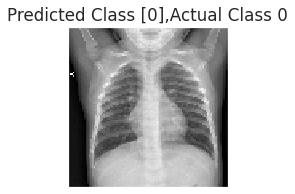

In [41]:
#-----------------------------------Global Definitions 3-----------------------------------#

# Define 1:  train & validation loss
train_loss = history.history['loss']
val_loss = history.history['val_loss']

## Define 2: train & validation AUC
train_auc_name = list(history.history.keys())[3]
val_auc_name = list(history.history.keys())[1]
train_auc = history.history[train_auc_name]
val_auc = history.history[val_auc_name]

## Define 3: y_pred & y_true : y_test
prediction_probability1 = model.predict(x_test)
prediction_class1= model.predict_classes(x_test)
y_pred = (prediction_class > 0.5).T[0]
y_pred_prob = prediction_probability.T[0]

show_predection_examples(prediction_class1,prediction_probability1,4)

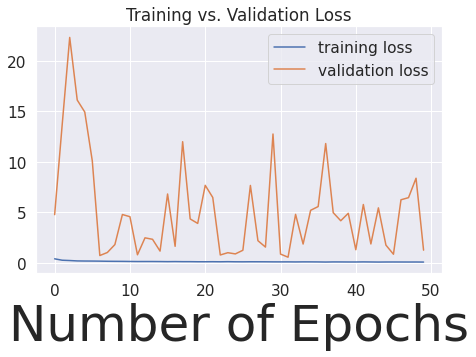

In [42]:
#Building Plots 3#
fig = plt.figure(figsize=(16, 10))

# PLOT 1: TRAIN VS. VALIDATION LOSS epoch 50
plt.subplot(2,2,1)
plt.title("Training vs. Validation Loss")
plt.plot(train_loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.xlabel("Number of Epochs", size = EPOCHS)
plt.legend()

Text(79.5, 0.5, 'Actual')

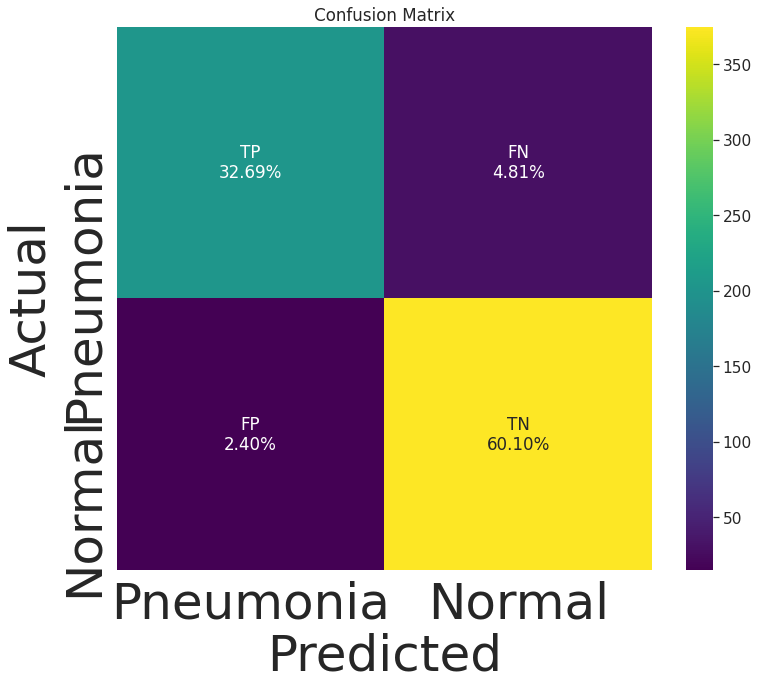

In [51]:
# PLOT 2: CONFUSION MATRIX
fig = plt.figure(figsize=(12, 10))

    # Set up the labels for in the confusion matrix
cm = confusion_matrix(y_test, y_pred)
names = ['TP', 'FN', 'FP', 'TN']
counts = ['{0:0.0f}'.format(value) for value in cm.flatten()]
percentages = ['{0:.2%}'.format(value) for value in cm.flatten()/np.sum(cm)]
labels = [f'{v1}\n{v2}' for v1, v2 in zip(names, percentages)]
labels = np.asarray(labels).reshape(2,2)
ticklabels = ['Pneumonia','Normal']

    # Create confusion matrix as heatmap
sns.set(font_scale = 1.4)
ax = sns.heatmap(cm, annot=labels, fmt='', cmap='viridis', xticklabels=ticklabels, yticklabels=ticklabels )
plt.xticks(size=EPOCHS)
plt.yticks(size=EPOCHS)
plt.title("Confusion Matrix")
plt.xlabel("Predicted", size= EPOCHS)
plt.ylabel("Actual", size= EPOCHS) 



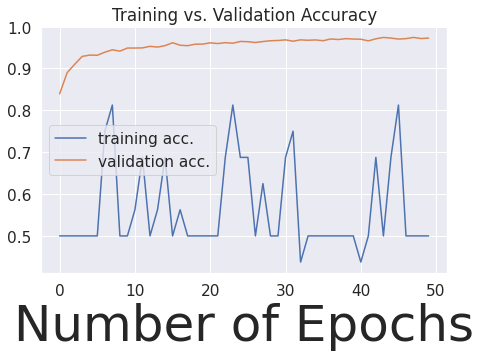

In [52]:
# PLOT 3: TRAIN VS. VALIDATION AUC
fig = plt.figure(figsize=(16, 10))
plt.subplot(2,2,2)
plt.title("Training vs. Validation Accuracy")
plt.plot(train_auc, label='training acc.')
plt.plot(val_auc, label='validation acc.')
plt.xlabel("Number of Epochs", size = EPOCHS)
plt.legend()

[Classification Metrics Summary]
Accuracy = 92.79% | Precision = 92.59% | Recall = 96.15% | Specifity = 87.18% | F1 Score = 94.34%


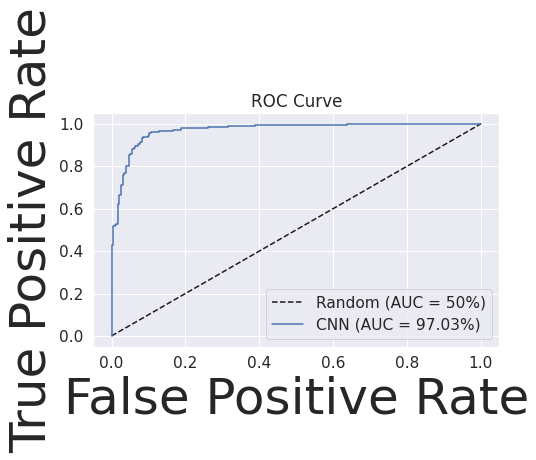

In [53]:
# PLOT 4: ROC CURVE
fig = plt.figure(figsize=(14, 10))
plt.subplot(2,2,4)
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
auc = roc_auc_score(y_test, y_pred_prob)
plt.title('ROC Curve')
plt.plot([0, 1], [0, 1], 'k--', label = "Random (AUC = 50%)")
plt.plot(fpr, tpr, label='CNN (AUC = {:.2f}%)'.format(auc*100))
plt.xlabel('False Positive Rate', size = EPOCHS)
plt.ylabel('True Positive Rate', size = EPOCHS)
plt.legend(loc='best')

# END PLOTS
plt.tight_layout()

# Summary Statistics

    #Accuracy : 1 - (Average Classification Error) = (TP + TN) / (TP + FN + TN + FP)  --> % positive out of all predicted positives
    #Precision : how many selected items are relevant = TP / (TP + FP)                --> % positive out of all predicted positives
    #Recall : how many relevant items are selected = TP / (TP + FN)                   --> % positive out of all supposed to be positives
    #Specifity :                                                                      --> % negative out of all supposed to be negatives
    #F1-score : harmonic mean between Precision and Recall = (2*precision * recall) / (precision + recall)

#cm[0,0], cm[0, 1], cm[1, 0], cm[1, 1]
TN, FP, FN, TP = cm.ravel()         
accuracy = (TP + TN) / np.sum(cm)   
precision = TP / (TP+FP)            
recall =  TP / (TP+FN)              
specifity = TN / (TN+FP)           
f1 = 2 * precision * recall / (precision + recall)
stats_summary = '[Classification Metrics Summary]\nAccuracy = {:.2%} | Precision = {:.2%} | Recall = {:.2%} | Specifity = {:.2%} | F1 Score = {:.2%}'.format(accuracy, precision, recall, specifity, f1)
print(stats_summary)
